In [1]:
import torch
import torchvision
from torch import nn as nn
from torch.nn.utils.rnn import pack_padded_sequence

from settings import EPOCHS
from unet import UNET
from Discriminator import Discriminator
import torchvision.transforms as transforms
from torch.nn import SoftMarginLoss
from torch.optim import Adam
from torch.utils.tensorboard import SummaryWriter

import matplotlib.pyplot as plt
import numpy as np
import matplotlib.image as mpimg



def trainPix2Pix(model, data, totalEpochs=EPOCHS, genLr=0.0001, descLr=0.00005):
    genOptimizer = Adam( list(model.gen.parameters()), lr=genLr)
    discOptimizer = Adam( list(model.disc.parameters()), lr=descLr)
    criterion = SoftMarginLoss()
    model.gen.train()
    model.disc.train()
    for epoch in range(totalEpochs):
        for minibatch, (color_and_gray, gray_three_channel) in enumerate(data):
            gradientStepPix2Pix(model, color_and_gray.cuda(), gray_three_channel.cuda(), criterion, genOptimizer, discOptimizer)


# assumes minibatch is only colord images.
def gradientStepPix2Pix(model, color, gray, criterion, genOptimizer, discOptimizer):
    origBW = gray
    origColor = color

    # train descriminator
    genColor = model.generate(origBW)
    genPairs = torch.cat((origBW, genColor), 3)
    origPairs = torch.cat((origBW, origColor), 3)

    descTrainSet = torch.cat((genPairs, origPairs), 0)
    genLabels = torch.zeros(genPairs.size()[0],1).cuda()
    origLabels =  torch.ones(origPairs.size()[0],1).cuda()
    labels = torch.cat((genLabels,origLabels),0)
    preds = model.discriminate(descTrainSet)
    batch_loss = criterion(preds, labels)

    model.gen.zero_grad()
    model.disc.zero_grad()
    batch_loss.backward()
    discOptimizer.step()

    genColor = model.generate(origBW)
    genPairs = torch.cat((origBW, genColor), 3)
    preds = model.discriminate(genPairs)
    batch_loss = criterion(preds,  torch.ones(genLabels.size()[0], 1).cuda())
    model.gen.zero_grad()
    model.disc.zero_grad()
    batch_loss.backward()
    genOptimizer.step()


class pix2pix(nn.Module):

    def __init__(self):
        super(pix2pix, self).__init__()
        numclasses = 3 #RGB
        numchannels = 64
        self.gen = UNET(numclasses, numchannels)
        self.disc = Discriminator()
#         self.criterion = CrossEntropyLoss()
        self.writer = SummaryWriter('runs/pix2pix')

    def log_image(self, images):
        # write to tensorboard
        img_grid = torchvision.utils.make_grid(images)
        self.writer.add_image('four_fashion_mnist_images', img_grid)

    def log_metrics(self, epoch, loss):
        self.writer.add_scalar('training loss', loss, epoch)
        self.trainData.append(loss)

    def generate(self, greyscale):
        return self.gen(greyscale)
        #Need to add dropout

    def discriminate(self, img):
        #(images, features, height, width)
        # Return average - 1 value for all images
        return self.disc(img)


In [2]:
def TenToPic(image):
    s = image.size()
    ret = torch.zeros(s[1], s[2], s[0])
    for i in range(s[0]):
        ret[:, :, i] = image[i, :,:]
    return ret.detach().numpy().astype(int)

In [3]:
from utils import get_datasets
train_dataset, test_dataset = get_datasets()
ex = None
for i in train_dataset:
    ex = i

In [4]:
model = pix2pix().cuda()
# out = model.generate(ex[1])
# plt.imshow(TenToPic(out[0,:,:,:]))
# plt.figure()
# plt.imshow(out.detach().numpy()[0,0,:,:])
plt.figure()
plt.imshow(TenToPic(ex[0][0,:,:,:]))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

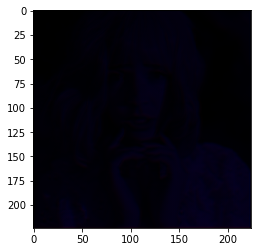

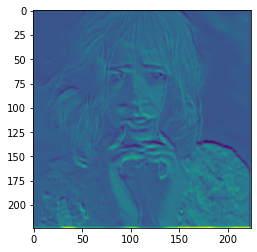

<Figure size 432x288 with 0 Axes>

In [11]:
cpuModel = model.cpu()
out = model.generate(ex[1])
plt.imshow(TenToPic(out[0,:,:,:]))
plt.figure()
plt.imshow(out.detach().numpy()[0,0,:,:])
plt.figure()

In [20]:
trainPix2Pix(model, train_dataset, totalEpochs=10, genLr=0.01, descLr=0.005)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


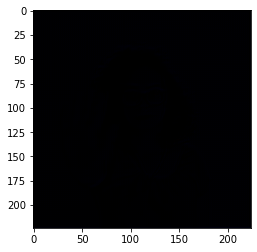

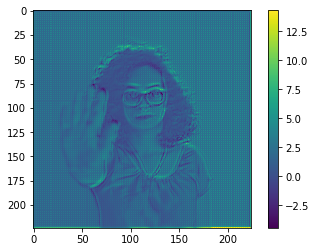

<Figure size 432x288 with 0 Axes>

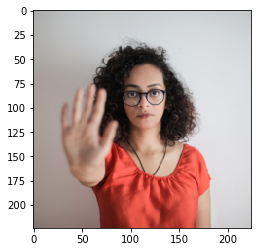

In [21]:
cpuModel = model.cpu()
out = model.generate(ex[1])
plt.imshow(TenToPic(out[0,:,:,:]))
plt.figure()
plt.imshow(out.detach().numpy()[0,2,:,:])
plt.colorbar()
plt.figure()
model.cuda()
temp = 1
plt.figure()
plt.imshow(TenToPic(ex[0][0,:,:,:]))